In [ ]:
# Australian Geoscience Datacube
## Feature Summary Examples

The [Australian Geoscience Datacube](https://github.com/data-cube/agdc-v2) provides an integrated gridded data analysis environment for decades of analysis ready earth observation satellite and related data from multiple satellite and other acquisition systems.

For instructions on using the Datacube on NCI, see: http://agdc-v2.readthedocs.io/en/develop/nci_usage.html

For instructions on setting up your own instance, see: http://agdc-v2.readthedocs.io/en/develop/install.html

This notebook touches briefly on some the implimented features of the Datacube module, and is only intended to deomstrat functionality rather than be a tutorial.

In [1]:
%pylab notebook
#%pylab inline
#%matplotlib inline
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt
import matplotlib.dates
import json
import pandas as pd
from IPython.display import display
import ipywidgets as widgets
import fiona
import shapely
import shapely.geometry
from shapely.geometry import shape
import rasterio
import matplotlib.gridspec as gridspec


Populating the interactive namespace from numpy and matplotlib


If you have set up your config correctly, or are using the module on NCI, you should be able to make `Datacube` object that can connects to the configured datacube system.

In [2]:
dc = datacube.Datacube(app='dc-example')
dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://lxl554@130.56.244.227:6432/datacube)>>>

## Datacube products and measurements
The Datacube provides pandas.DataFrame representations of the available products and measurements:

In [97]:
dc.list_products()

,name,description,product_type,sat_path,format,lon,platform,sat_row,instrument,time,lat,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
36,bom_rainfall_grids,Interpolated Rain Gauge Precipitation 1-Day Au...,rainfall,NaN,NETCDF,NaN,BoM,NaN,rain gauge,None,NaN,EPSG:4326,"[-0.05, 0.05]",None,"(latitude, longitude)"
32,dsm1sv10,DSM 1sec Version 1.0,DEM,NaN,ENVI,NaN,SRTM,NaN,SIR,None,NaN,EPSG:4326,"[-0.00027777777778, 0.00027777777778]",None,"(latitude, longitude)"
27,ls5_fc_albers,"Landsat 5 Fractional Cover 25 metre, 100km til...",fractional_cover,NaN,NetCDF,NaN,LANDSAT_5,NaN,TM,None,NaN,EPSG:3577,"[-25, 25]","[100000.0, 100000.0]","(y, x)"
2,ls5_level1_scene,Landsat 5 Level 1 At-sensor Radiance 25 metre,level1,NaN,GeoTiff,NaN,LANDSAT_5,NaN,TM,None,NaN,NaN,NaN,NaN,NaN
6,ls5_nbar_albers,"Landsat 5 Surface Reflectance NBAR 25 metre, 1...",nbar,NaN,NetCDF,NaN,LANDSAT_5,NaN,TM,None,NaN,EPSG:3577,"[-25, 25]","[100000.0, 100000.0]","(y, x)"
3,ls5_nbar_scene,Landsat 5 NBAR 25 metre,nbar,NaN,GeoTiff,NaN,LANDSAT_5,NaN,TM,None,NaN,NaN,NaN,NaN,NaN
26,ls5_nbart_albers,"Landsat 5 Surface Reflectance NBART 25 metre, ...",nbart,NaN,NetCDF,NaN,LANDSAT_5,NaN,TM,None,NaN,EPSG:3577,"[-25, 25]","[100000.0, 100000.0]","(y, x)"
4,ls5_nbart_scene,Landsat 5 NBART 25 metre,nbart,NaN,GeoTiff,NaN,LANDSAT_5,NaN,TM,None,NaN,NaN,NaN,NaN,NaN
37,ls5_ndvi_albers,Landsat 5 Normalised Difference Vegetation Ind...,ndvi,NaN,NetCDF,NaN,LANDSAT_5,NaN,TM,None,NaN,EPSG:3577,"[-25, 25]","[100000.0, 100000.0]","(y, x)"


## Datacube Measurements
The list of measurements stored in the datacube can also be listed.

Measurements are also known as _bands_ in the imagery domain, and _data variables_ when stored in NetCDF files or when working with `xarray.Dataset` objects.

In [116]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords
#Either as polygon or as lat/lon range

#Define temporal range
start_of_epoch = '1986-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-12-31'



#Define sensors of interest
sensor1 = 'ls7'
"""sensor2 = 'ls7'
sensor3 = 'ls5'"""

query = {
    'time': (start_of_epoch, end_of_epoch),
}

#query.update(geom_query(geom)) #comment this out if not using a polygon

#If not using a polygon/polyline, enter lat/lon here manually
lat_max = -34.73
lat_min = -34.86
lon_max = 150.81
lon_min = 150.75
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [117]:
print query

{'y': (-34.73, -34.86), 'x': (150.75, 150.81), 'crs': 'EPSG:4326', 'time': ('1986-01-01', '2016-12-31')}


## Retrieve surface reflectance data


In [118]:
#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensor1+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest, src):
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

In [119]:
#load sensor specific band adjustment tuples for TSS and brightness

# retrieve the NBAR and PQ for the spatiotemporal range of interest


In [120]:
#Retrieve the NBAR and PQ data for sensor n
sensor1_ndvi = dc.load(product= sensor1+'_ndvi_albers', group_by='solar_day',  **query)
sensor1_pq = dc.load(product= sensor1+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
            

In [121]:
sensor1_ndvi

<xarray.Dataset>
Dimensions:  (time: 6, x: 302, y: 606)
Coordinates:
  * time     (time) datetime64[ns] 1999-07-19 1999-07-26 1999-08-20 ...
  * y        (y) float64 -3.917e+06 -3.917e+06 -3.917e+06 -3.917e+06 ...
  * x        (x) float64 1.703e+06 1.703e+06 1.703e+06 1.703e+06 1.703e+06 ...
Data variables:
    ndvi     (time, y, x) int16 8508 8746 8542 8189 7866 8626 7947 6491 6491 ...
Attributes:
    crs: EPSG:3577

In [122]:
#This line exists to make sure that there's a 1:1 match between NBAR and PQ
sensor1_pq = sensor1_pq.sel(time = sensor1_ndvi.time)

In [123]:
#Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
#Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
s1_cloud_free = masking.make_mask(sensor1_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s1_good_data = s1_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor1_ndvi = sensor1_ndvi.where(s1_good_data)

In [124]:
sensor1_nbar = dc.load(product= sensor1+'_nbar_albers', group_by='solar_day',  **query)
sensor1_pq = dc.load(product= sensor1+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

In [125]:
sensor1_nbar = sensor1_nbar.sel(time = sensor1_ndvi.time)

In [126]:
s1_cloud_free = masking.make_mask(sensor1_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s1_good_data = s1_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor1_nbar = sensor1_nbar.where(s1_good_data)

In [127]:
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NBR', 'NDWI','TSS']
sensor1_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor2_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor2_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor2_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    sensor1_rsindex['NDVI'] = ((sensor1_nbar['nir']-sensor1_nbar['red'])/(sensor1_nbar['nir']+sensor1_nbar['red']))
    #sensor2_rsindex['NDWI'] = ((sensor2_nbar['swir1']-sensor2_nbar['green'])/(sensor2_nbar['swir1']+sensor2_nbar['green']))
    #sensor2_rsindex['NBR'] = ((sensor2_nbar['nir']-sensor2_nbar['swir2'])/(sensor2_nbar['nir']+sensor2_nbar['swir2']))
    #sensor2_rsindex['TSS'] = (ls7_tss_constant*((sensor2_nbar['green']+sensor2_nbar['red'])/20000)**ls7_tss_exponent)


In [128]:
#sensor1_ndvi

<IPython.core.display.Javascript object>


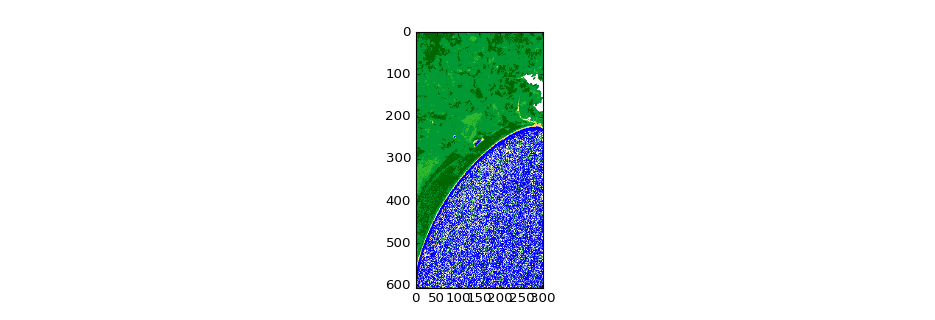

In [141]:
fig = plt.figure(figsize=(11.69,4))
time_slice = 2
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.2, 0.3, 0.5, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)
imshow(sensor1_rsindex['NDVI'].isel(time = time_slice), cmap = ndvi_cmap, norm = ndvi_norm)




<IPython.core.display.Javascript object>


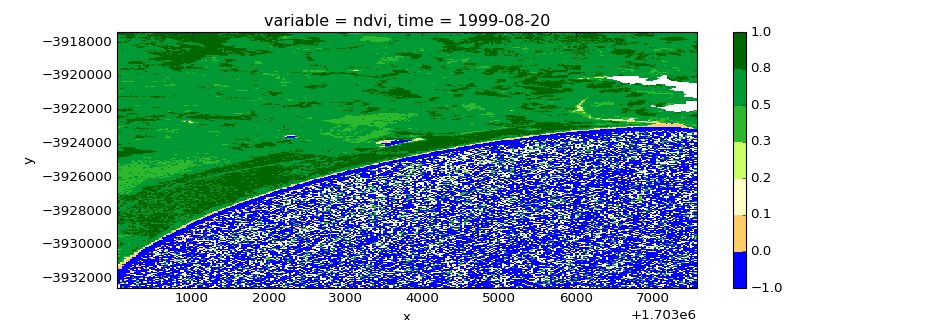

In [144]:
#select time slice of interest
fig = plt.figure(figsize=(11.69,4))
ndvi_rescale = sensor1_ndvi/10000
ndvi_timeslice = ndvi_rescale.isel(time =time_slice).to_array().plot(cmap = ndvi_cmap, norm = ndvi_norm)
ndvi_timeslice
#imshow(ndvi_timeslice) #cmap = ndvi_cmap, norm = ndvi_norm)
#ndvi_timeslice
#imshow(scaled, interpolation = 'nearest')

<IPython.core.display.Javascript object>


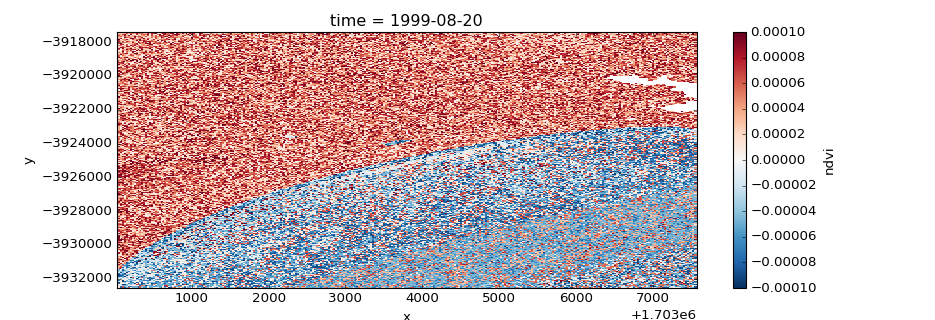

In [145]:
fig = plt.figure(figsize=(11.69,4))
diff = (sensor1_rsindex['NDVI'].isel(time = time_slice))-(ndvi_rescale.isel(time = time_slice))
diff.ndvi.plot()